Egg Detection with DETR_Custom Dataset


In [1]:
# Importing libraries
from PIL import Image
import matplotlib.pyplot as plt
import os
import glob


import torch
import torchvision.transforms as T
import torchvision
from models import build_model

In [2]:
# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

CLASSES = [
    'None',
    'Normal',
    'Blood Spot',
    'Crack',
    'Bleached',
    'Impurity',
    'Deformity',
    'Latent Crack',
    'N/A'
]

In [3]:
# Create arguments class for build DETR model
class Args:
    lr_backbone = 2e-4
    masks = None
    # Model parameters
    frozen_weights = None
    backbone = 'resnet50'
    dilation = False
    position_embedding = 'sine'
    enc_layers = 6
    dec_layers = 6
    dim_feedforward = 2048
    hidden_dim = 256
    dropout = 0.1
    nheads = 8
    num_queries = 100
    pre_norm = False
    aux_loss = False
    num_classes = 9
    set_cost_class=1
    set_cost_bbox=5
    set_cost_giou=2
    mask_loss_coef=1
    dice_loss_coef=1
    bbox_loss_coef=5
    giou_loss_coef=2
    eos_coef=0.1
    num_bbox_reg_classes = 2
    # Dataset parameters
    dataset_file = 'coco'
    coco_path = ''
    remove_difficult = False
    coco_panoptic_path = None
    # Device parameters
    device = 'cuda'
    seed = 42
    # Misc
    output_dir = ''
    resume = './outputs/best_Mono.pth' # Path to load weights model


args = Args()

In [9]:
# Preprocess image - Get list of images
def collect_all_images(dir_test):
    """
    Function to return a list of image paths.

    :param dir_test: Directory containing images or single image path.

    Returns:
        test_images: List containing all image paths.
    """
    test_images = []
    if os.path.isdir(dir_test):
        image_file_types = ['*.jpg', '*.jpeg', '*.png', '*.ppm']
        for file_type in image_file_types:
            test_images.extend(glob.glob(f"{dir_test}/{file_type}"))
    else:
        test_images.append(dir_test)
    return test_images   

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_min, y_min, w, h = x.unbind(1)
    b = [x_min - 0.5 * w, y_min - 0.5 * h, x_min + 0.5 * w, y_min + 0.5 * h]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [10]:
# Compute distance between two points (x1, y1) and (x2, y2)
def distance(x, y):
    return ((x[0] - y[0])**2 + (x[1] - y[1])**2)**0.5

# Put everything on detect function
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.8

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    #bboxes_scaled = bboxes_scaled.tolist()

    return probas[keep], bboxes_scaled

def Select_Bounding_Boxes(probas, bboxes_scaled):

    # Finding the center coordinates of the bounding box
    center_x = (bboxes_scaled[:, 0] + bboxes_scaled[:, 2]) / 2
    center_y = (bboxes_scaled[:, 1] + bboxes_scaled[:, 3]) / 2

    # Combine center_x and center_y to get the center coordinates
    center = torch.stack((center_x, center_y), dim=1)
    center = center.tolist()
    print(center)

    # Remove the center coordinates that are too close to each other
    dist = 0
    index_remove = []
    for i in range(len(center)):
        for j in range(i + 1, len(center)):
            dist = distance(center[i], center[j])
            if dist < 50:
                # Remove the center with the lower confidence
                if probas[i].max() > probas[j].max():
                    index_remove.append(j)
                else:
                    index_remove.append(i)

    print(index_remove)

    bboxes_scaled = bboxes_scaled.tolist()
    probas = probas.tolist()

    # Delete bounding boxes having index in index_remove
    # Sort index_remove in descending order
    index_remove.sort(reverse=True)
    for i in index_remove:
        del bboxes_scaled[i]
        del probas[i]
    
    # Convert list to tensor
    probas = torch.tensor(probas)
    return probas, bboxes_scaled


def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    pil_img = plt.imread(pil_img)
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes, COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

Detecting Eggs with DETR - DEMO with a Single Color Image


Number bounding boxes before:  16
[[1045.229736328125, 880.4335327148438], [1044.6591796875, 882.1024169921875], [806.68359375, 216.96742248535156], [565.02734375, 552.452392578125], [568.2194213867188, 885.3133544921875], [1047.1007080078125, 548.09423828125], [1047.515380859375, 547.8233642578125], [1044.555908203125, 217.07870483398438], [566.524169921875, 216.97120666503906], [566.129638671875, 553.57666015625], [329.91162109375, 882.9683837890625], [326.5686950683594, 550.64697265625], [327.64703369140625, 217.67276000976562], [808.4791259765625, 215.21905517578125], [1046.404296875, 215.33029174804688], [808.15673828125, 551.8050537109375]]
[1, 2, 3, 6, 7]
Number bounding boxes after:  11


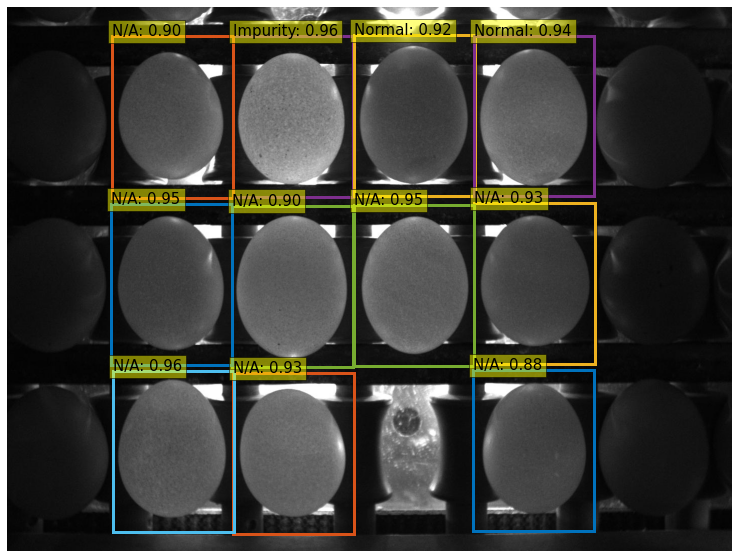

In [11]:
# Load model
model, criterion, postprocessors = build_model(args)
checkpoint = torch.load(args.resume, map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=False)

# Inference phase visualization
image = './MONO_Images_Demo/0505133001_0_06348.jpg'
img = Image.open(image)
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


scores, boxes = detect(img, model, transform)
print('Number bounding boxes before: ', len(boxes))
scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
print('Number bounding boxes after: ', len(boxes_1))
plot_results(image, scores_1, boxes_1)


Detecting Eggs with DETR - DEMO with Multiple Color Images

Number bounding boxes before:  11
[[1064.8714599609375, 863.968017578125], [356.3707275390625, 199.02227783203125], [835.572021484375, 204.4638214111328], [590.5280151367188, 867.990234375], [590.1686401367188, 867.650390625], [350.9993591308594, 865.7275390625], [356.2411804199219, 200.9214630126953], [596.7689208984375, 199.48495483398438], [1065.1605224609375, 865.8182373046875], [831.6538696289062, 536.84619140625], [1074.61328125, 204.34288024902344]]
[8, 1, 4]
Number bounding boxes after:  8


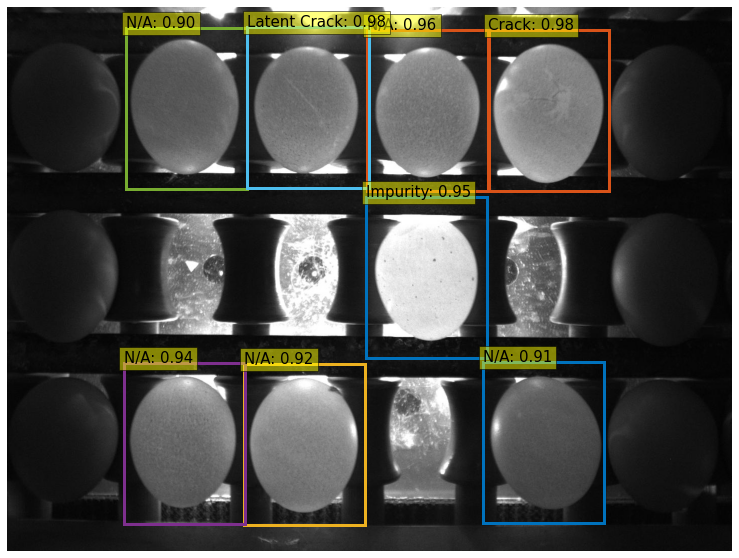

Number bounding boxes before:  13
[[328.82135009765625, 884.912841796875], [566.8005981445312, 217.37489318847656], [1049.72802734375, 883.702880859375], [326.9677429199219, 214.4180908203125], [1051.01904296875, 553.7348022460938], [807.4691162109375, 218.0445556640625], [567.9074096679688, 884.741455078125], [1048.85205078125, 220.63589477539062], [567.53759765625, 215.3601837158203], [807.98876953125, 887.3133544921875], [329.22296142578125, 885.3077392578125], [327.7294006347656, 551.2931518554688], [808.2403564453125, 216.67730712890625]]
[0, 1, 12]
Number bounding boxes after:  10


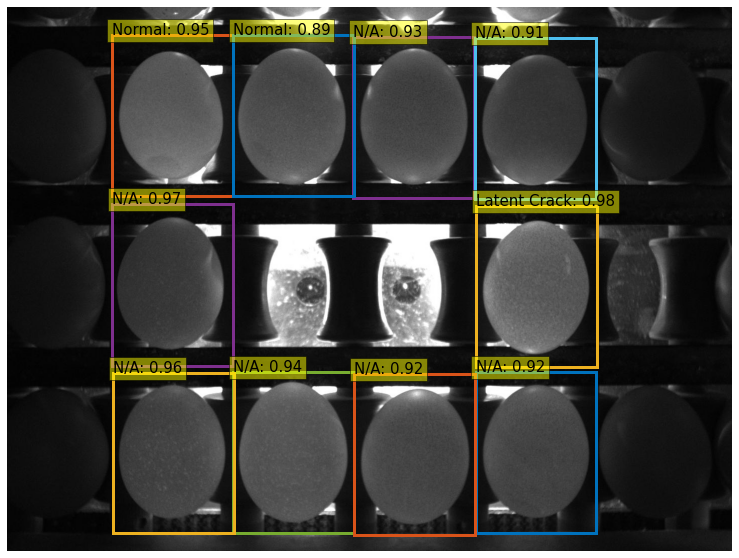

Number bounding boxes before:  10
[[567.13671875, 212.16517639160156], [1049.26708984375, 879.5230712890625], [326.2895202636719, 211.3596649169922], [807.322021484375, 211.76329040527344], [1048.0189208984375, 214.1707763671875], [566.9368286132812, 210.68020629882812], [565.3153076171875, 545.9129638671875], [323.73748779296875, 550.8648071289062], [327.0267333984375, 211.15252685546875], [808.098876953125, 545.070556640625]]
[5, 2]
Number bounding boxes after:  8


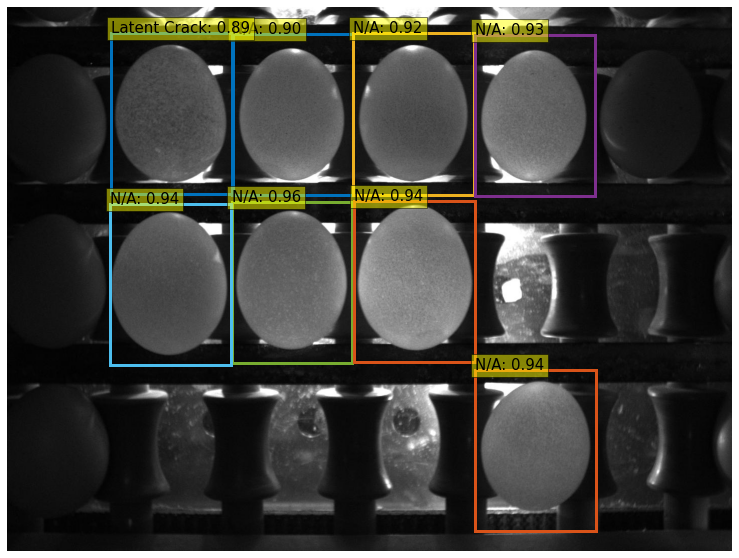

Number bounding boxes before:  14
[[566.6463623046875, 216.091552734375], [1048.311279296875, 881.2979736328125], [807.024658203125, 213.876220703125], [1049.83544921875, 551.3609008789062], [1045.33251953125, 212.2891387939453], [805.10205078125, 881.8319091796875], [564.9185791015625, 550.65771484375], [323.6907043457031, 551.626953125], [326.1762390136719, 219.12164306640625], [329.76251220703125, 887.215087890625], [322.8994445800781, 551.5313110351562], [1047.757080078125, 881.8703002929688], [805.4081420898438, 882.9702758789062], [805.544189453125, 550.8998413085938]]
[11, 12, 10]
Number bounding boxes after:  11


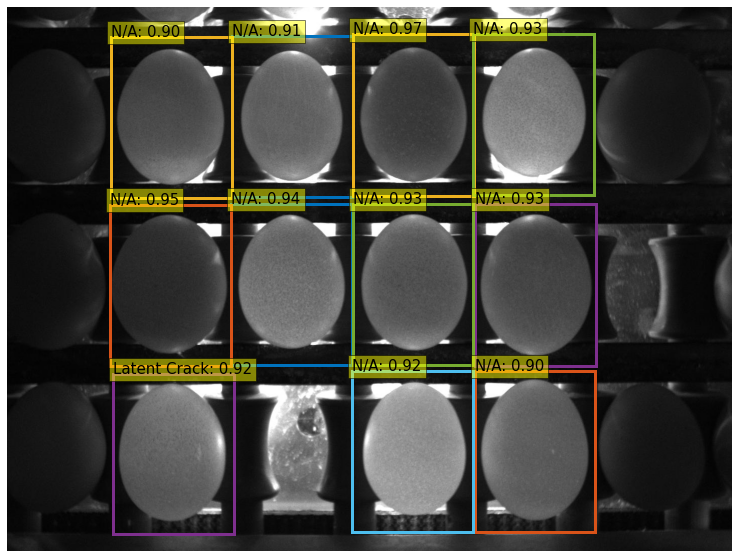

Number bounding boxes before:  15
[[1048.6494140625, 874.5577392578125], [805.6825561523438, 206.0569305419922], [566.1456298828125, 542.8768920898438], [1049.066162109375, 542.160400390625], [1047.2415771484375, 207.47779846191406], [565.3267822265625, 208.70489501953125], [806.5880737304688, 877.364990234375], [565.5144653320312, 543.2493286132812], [325.5285339355469, 548.1171875], [329.774169921875, 208.29222106933594], [330.6663818359375, 211.09793090820312], [325.29119873046875, 547.28662109375], [1046.931884765625, 876.335205078125], [1045.9246826171875, 206.03173828125], [807.7332153320312, 541.4261474609375]]
[12, 2, 4, 11, 9]
Number bounding boxes after:  10


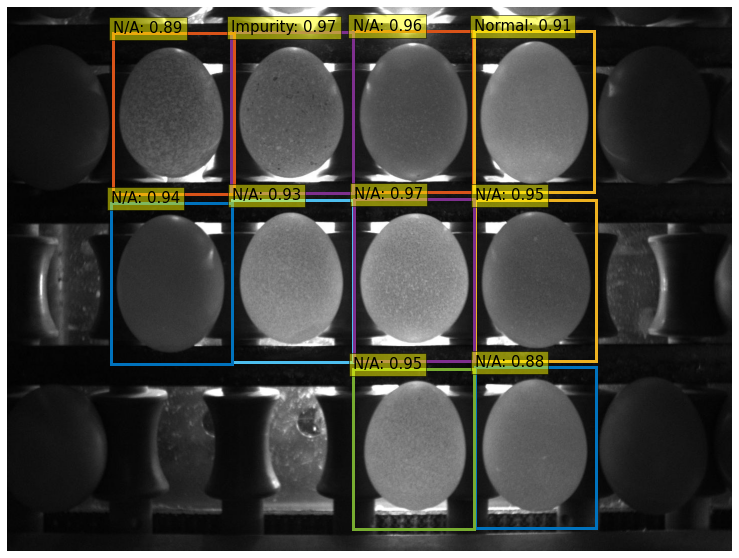

Number bounding boxes before:  17
[[567.6026000976562, 216.88998413085938], [1049.9327392578125, 883.0723876953125], [325.9532165527344, 216.73150634765625], [808.3875122070312, 215.88763427734375], [566.8644409179688, 547.3936157226562], [568.709716796875, 888.041015625], [1049.6578369140625, 547.8056640625], [568.135009765625, 887.4790649414062], [809.6591796875, 885.9459228515625], [565.409423828125, 548.0751342773438], [331.1914367675781, 884.9600830078125], [324.41143798828125, 215.4274444580078], [1050.07177734375, 883.6254272460938], [809.6162109375, 551.0629272460938], [1048.9779052734375, 214.9557342529297], [809.0584716796875, 885.5814819335938], [808.114013671875, 551.5607299804688]]
[1, 11, 9, 7, 15, 13]
Number bounding boxes after:  11


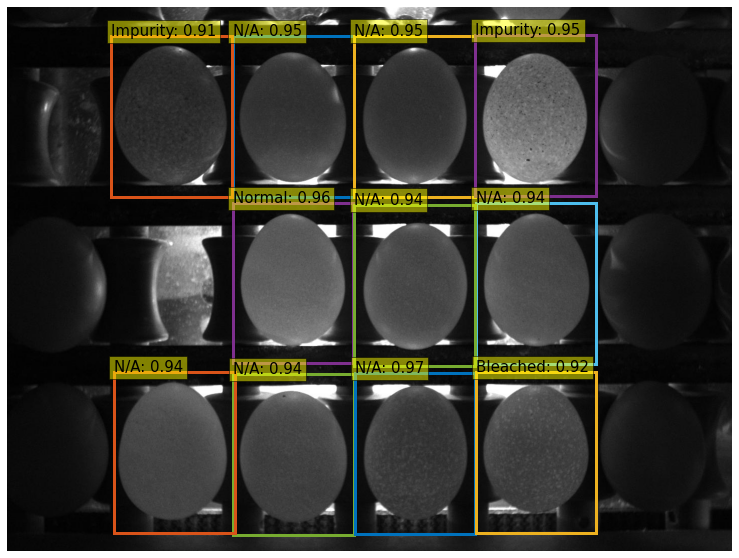

Number bounding boxes before:  14
[[1044.78369140625, 209.3865203857422], [805.415771484375, 211.13951110839844], [561.1447143554688, 544.3092651367188], [565.1524658203125, 881.1668090820312], [1048.8533935546875, 545.1124267578125], [1048.57568359375, 544.2067260742188], [565.1431274414062, 879.892822265625], [808.220458984375, 881.700927734375], [560.9965209960938, 545.3443603515625], [329.98583984375, 879.7584228515625], [808.765625, 549.2523193359375], [563.9960327148438, 208.91204833984375], [807.968505859375, 881.26220703125], [807.7122802734375, 548.877685546875]]
[2, 3, 5, 12, 13]
Number bounding boxes after:  9


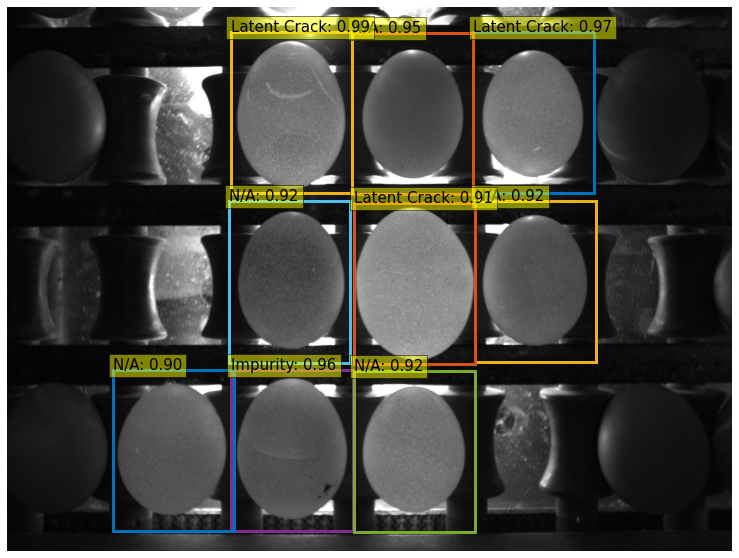

Number bounding boxes before:  14
[[568.0404052734375, 214.5427703857422], [327.8245544433594, 216.4490966796875], [1046.2557373046875, 878.8151245117188], [567.3133544921875, 545.5477294921875], [566.9619140625, 880.8453979492188], [1046.95947265625, 216.6063995361328], [567.74755859375, 881.3153076171875], [807.3052368164062, 881.06298828125], [566.264404296875, 546.4832763671875], [330.17132568359375, 881.57763671875], [327.51708984375, 549.1946411132812], [328.02301025390625, 217.17556762695312], [327.24664306640625, 547.6446533203125], [1048.372314453125, 879.4415283203125]]
[1, 2, 8, 6, 10]
Number bounding boxes after:  9


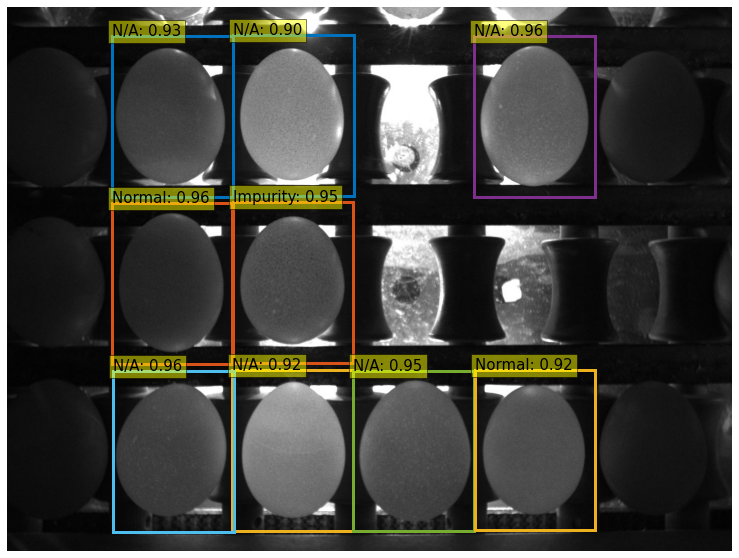

Number bounding boxes before:  14
[[331.4327087402344, 881.2998046875], [569.6248779296875, 215.8076934814453], [1050.427001953125, 877.5155029296875], [810.6965942382812, 216.53854370117188], [570.2035522460938, 880.3742065429688], [1052.8851318359375, 542.6564331054688], [809.9688720703125, 879.0325927734375], [567.2554321289062, 545.4710693359375], [329.0963134765625, 549.6026611328125], [330.23382568359375, 218.48631286621094], [570.8161010742188, 544.8605346679688], [809.7049560546875, 215.56033325195312], [810.3488159179688, 878.0687255859375], [811.6414794921875, 546.1470947265625]]
[11, 6, 7]
Number bounding boxes after:  11


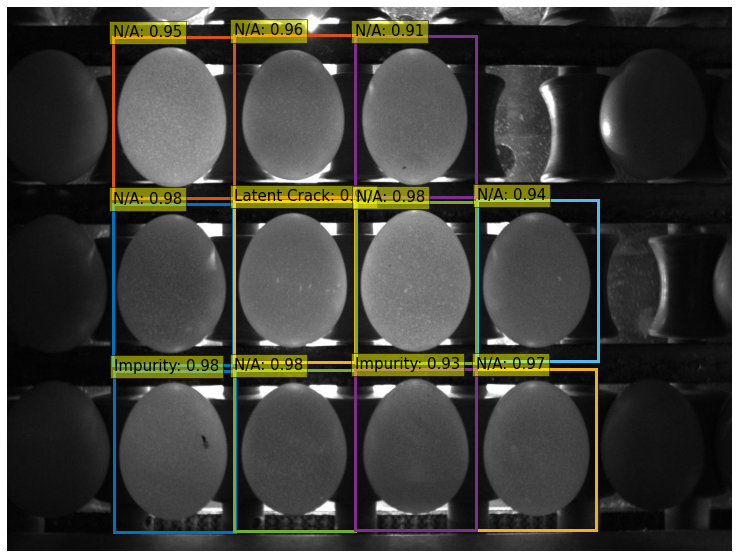

Number bounding boxes before:  16
[[346.5464782714844, 868.27392578125], [595.6388549804688, 198.4488067626953], [836.1919555664062, 200.8199462890625], [591.611083984375, 533.5873413085938], [590.2382202148438, 866.8108520507812], [1074.660400390625, 202.17759704589844], [591.6373901367188, 867.306884765625], [833.6632080078125, 864.1884765625], [591.6328125, 534.64501953125], [347.7557373046875, 866.0772705078125], [348.2513122558594, 533.6622924804688], [354.5021667480469, 199.64508056640625], [836.573486328125, 200.26998901367188], [835.9332275390625, 532.3413696289062], [832.5158081054688, 865.5543823242188], [835.237060546875, 533.22216796875]]
[0, 2, 3, 4, 7, 13]
Number bounding boxes after:  10


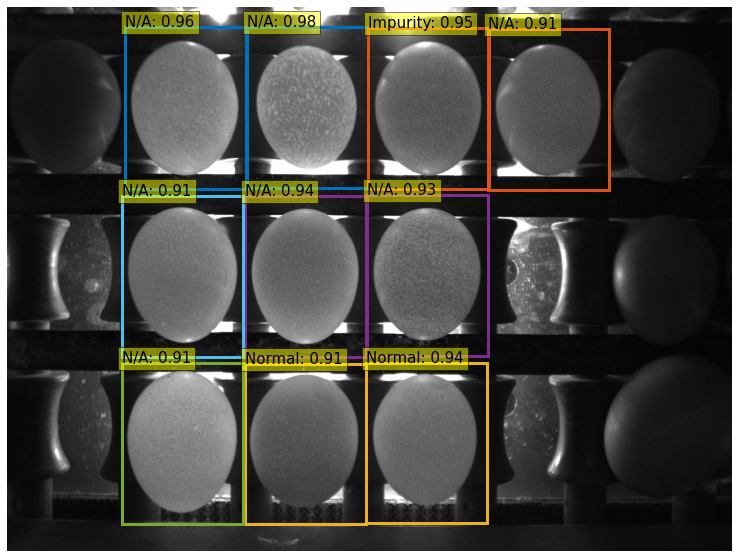

In [12]:
DIR_TEST = './MONO_Images_Demo/'
test_images = collect_all_images(DIR_TEST)

count = 0

for image in test_images:
    if (count == 10):
        break
    img = Image.open(image)

    scores, boxes = detect(img, model, transform)
    print('Number bounding boxes before: ', len(boxes))
    scores_1, boxes_1 = Select_Bounding_Boxes(scores, boxes)
    print('Number bounding boxes after: ', len(boxes_1))
    plot_results(image, scores_1, boxes_1)
    count += 1